In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import cv2 as cv
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import ToTensor

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

images_path = 'images/'
annotations_path = 'annotations/list.txt'

with open(annotations_path, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=columns)

df["Image"] = images_path + df["Image"] + '.jpg'
df["CLASS-ID"] = df["CLASS-ID"].astype('int64')
df["SPECIES"] = df["SPECIES"].astype('int64')
df["BREED ID"] = df["BREED ID"].astype('int64')

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].apply(lambda x: x - 1)

print(df)

                                Image  CLASS-ID  SPECIES  BREED ID
0           images/Abyssinian_100.jpg         0        0         0
1           images/Abyssinian_101.jpg         0        0         0
2           images/Abyssinian_102.jpg         0        0         0
3           images/Abyssinian_103.jpg         0        0         0
4           images/Abyssinian_104.jpg         0        0         0
...                               ...       ...      ...       ...
7344  images/yorkshire_terrier_96.jpg        36        1        24
7345  images/yorkshire_terrier_97.jpg        36        1        24
7346  images/yorkshire_terrier_98.jpg        36        1        24
7347  images/yorkshire_terrier_99.jpg        36        1        24
7348   images/yorkshire_terrier_9.jpg        36        1        24

[7349 rows x 4 columns]


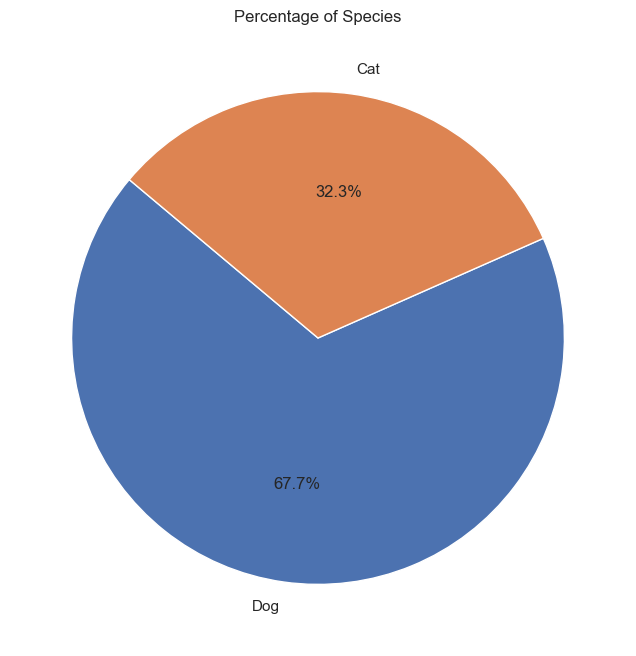

In [3]:
species_counts = df['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

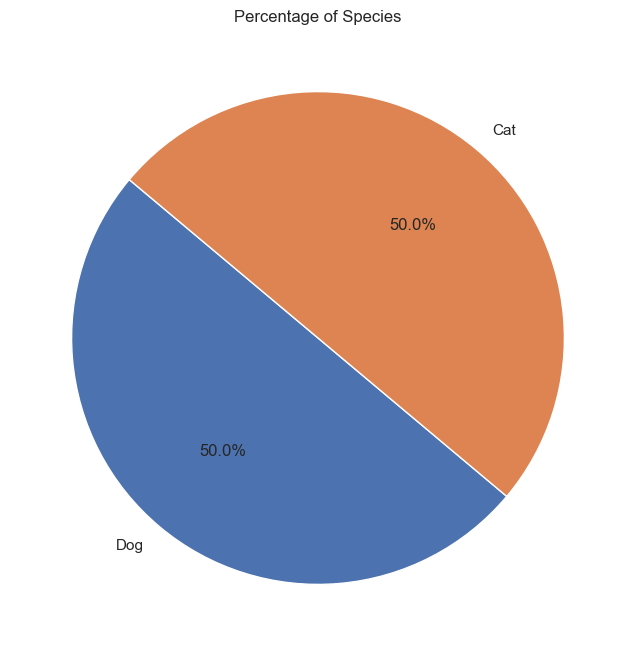

In [4]:
cats_df = df[df['SPECIES'] == 0]
dogs_df = df[df['SPECIES'] == 1]

min_samples = min(len(cats_df), len(dogs_df))
cats_sampled = cats_df.sample(n=min_samples, random_state=42)
dogs_sampled = dogs_df.sample(n=min_samples, random_state=42)

df_balanced = pd.concat([cats_sampled, dogs_sampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


species_counts = df_balanced['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

### OUR CNN

In [5]:
X = df_balanced[["Image"]]
y = df_balanced[["SPECIES"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for training and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([
    transforms.Resize((100, 100)),  
    transforms.ToTensor()
])

train_ds = DogsCats(train_df['Image'], train_df['SPECIES'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['SPECIES'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

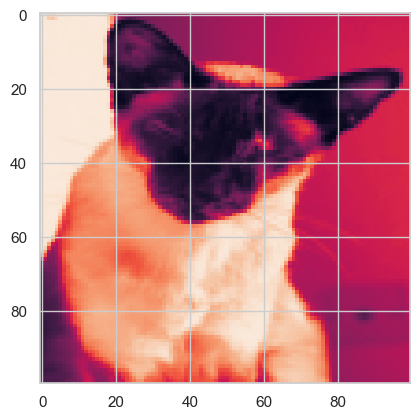

Etiqueta: 0
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 100, 100])
Labels batch shape: torch.Size([64])


In [6]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [7]:
from collections import OrderedDict

class SuperCNNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SuperCNNSuperGuay, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(16*25*25, 32)
        self.linear_2 = nn.Linear(32, 10)
        self.linear_3 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.max_pool2d(x)
        x = torch.flatten(x, 1)
        #x = self.dropout(x)
        x = self.relu(x)
        x = self.linear_1(x)
        #self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        x = self.linear_2(x)
        self.relu = nn.ReLU()
        x = self.linear_3(x)

        return F.log_softmax(x, dim=1)
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [

                ]
            )
        )

In [8]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        if batch_idx % log_interval == 0 and verbose:
            print(f'Starting epoch nº{batch_idx}')
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()        
        output = model(data)
        
        loss = F.cross_entropy(output, target, reduction='sum') 
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [ ]:
use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = SuperCNNSuperGuay().to(device)

epochs = 15
lr =0.00001

optimizer = Adam(model.parameters(), lr=lr)

# Guardam el valor de peèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_dl, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_dl)


Starting epoch nº0
Train Epoch: 0 [0/3793 (0%)]	Loss: 46.459637, Average: 0.725932

Train set: Average loss: 0.6951


Test set: Average loss: 0.6900, Accuracy: 499/949 (53%)

Starting epoch nº0
Train Epoch: 1 [0/3793 (0%)]	Loss: 44.481174, Average: 0.695018

Train set: Average loss: 0.6916

